# Copyright Netherlands eScience Center <br>
**Function     : Evaluate the robustness of forecast skills for different forecast date** <br>
**Author       : Yang Liu** <br>
**First Built   : 2021.06.23** <br>
**Last Update   : 2021.06.23** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to evaluate the robustness of forecast skills for different forecast date.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import random
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv

#sys.path.append("../")
sys.path.append("H:\\Creator_Zone\\Script_craft\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79


Bad key text.latex.unicode in file G:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file G:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file G:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.temp

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# datapath for output
base_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex'
output_path_fig = os.path.join(base_path, 'paperFig\\ultra_long_series')
output_path_data = os.path.join(base_path, 'ultra_long_series\\epoch3000_p100000_stdx16_layer3')
# data path of experiment
#path_pred = os.path.join(base_path, 'ultra_long_series\\epoch3000_p100000_stdx16_layer3\\base\\epoch_2400_2800')
#path_pred = os.path.join(base_path, 'ultra_long_series\\epoch3000_p100000_stdx16_layer3\\robust\\step_450_3300')
path_pred = os.path.join(base_path, 'ultra_long_series\\epoch3000_p100000_stdx16_layer3\\robust\\step_900_3750')

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    #num_steps = 2850
    #num_steps = 3300
    num_steps = 3750
    # cut-off point of initialization period
    #cut_off = 0
    #cut_off = 450
    cut_off = 900
    # target testing period
    test_len = 450

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>
========================================================================================================<br>
##### AR
The methods include AR and VAR, which are based on <br>
Lütkepohl, H. (2005). New introduction to multiple time series analysis. Springer Science & Business Media.<br>
========================================================================================================<br>



In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

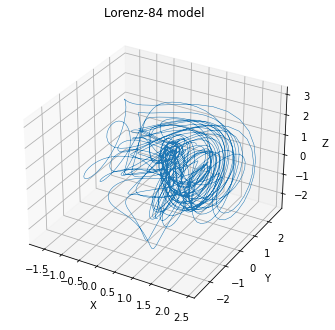

<Figure size 432x288 with 0 Axes>

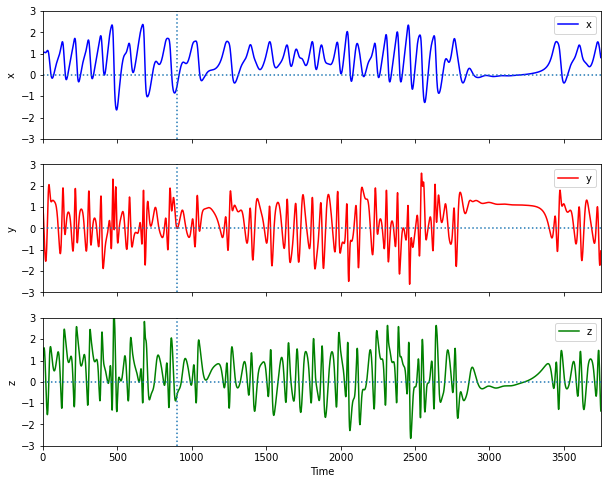

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                 ###########
    #################################################################################
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    # maximum and minimum
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)

    # build the input data structure
    series_full = np.zeros((3, num_steps-cut_off), dtype=float)
    series_full[0,:] = x[:]
    series_full[1,:] = y[:]
    series_full[2,:] = z[:]

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [10]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 60 # unit time step
    # number of ensembles
    ens = 5
    predictand_bayes = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred_bayes = Dataset(os.path.join(path_pred, 'pred_lorenz84_ens_{}.nc'.format(i)))
        predictand_bayes[i,:,:,:] = dataset_pred_bayes.variables['series'][:,:,:step_lead]     
    print(predictand_bayes.shape)
    predictand_median = np.median(predictand_bayes, 0)
    
    predictand_median_root = np.zeros((3, test_len, step_lead+1), dtype=float)
    predictand_median_root[0,:,0] = x_norm[-test_len-1:-1]
    predictand_median_root[1,:,0] = y_norm[-test_len-1:-1]
    predictand_median_root[2,:,0] = z_norm[-test_len-1:-1]
    predictand_median_root[:,:,1:] = predictand_median[:]    

*******************  load ensemble data  *********************
(5, 3, 450, 60)


In [11]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [12]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    step_lead_calc = 60
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    euclidean_bayes_ens = np.zeros((ens, step_lead+1), dtype=float)
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    predictand_bayes_denorm = np.zeros(predictand_bayes.shape, dtype=float)
    predictand_bayes_denorm[:,0,:,:] = predictand_bayes[:,0,:,:] * (x_max - x_min) + x_min
    predictand_bayes_denorm[:,1,:,:] = predictand_bayes[:,1,:,:] * (y_max - y_min) + y_min
    predictand_bayes_denorm[:,2,:,:] = predictand_bayes[:,2,:,:] * (z_max - z_min) + z_min
    
    for i in range(step_lead):
        for n in range(ens):
            euclidean_bayes_ens[n,i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_bayes_denorm[n,:,:,i])

    euclidean_bayes = np.mean(euclidean_bayes_ens, 0)
    
    np.savez_compressed(os.path.join(output_path_data,'eud.npz'), eud=euclidean_bayes_ens)

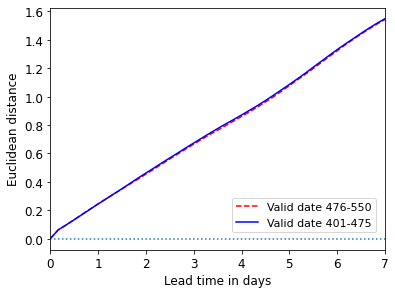

In [13]:
    ##################################################
    ###########       Preview Figure       ###########
    ##################################################    
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    display_upto = 42
   
    std_trajectory_ref = np.ones(display_upto+1,dtype=float)
    trajectory_std = np.std(np.sqrt(x**2 + y**2 + z**2))
    std_trajectory_ref = std_trajectory_ref * trajectory_std
    
    fig05 = plt.figure()
    fig05.set_size_inches(5.6, 4.2, forward=True)
    
    #plt.plot(np.arange(display_upto+1), euclidean_bayes_4[:], color='g', ls='--', label='Valid date 701-775')
    #plt.plot(np.arange(display_upto+1), euclidean_bayes_3[:], color='c', ls='--', label='Valid date 626-700')
    #plt.plot(np.arange(display_upto+1), euclidean_bayes_2[:], color='m', ls='--', label='Valid date 551-625')
    plt.plot(np.arange(display_upto+1), euclidean_bayes_ens[1, :display_upto+1], color='r', ls='--', label='Valid date 476-550')
    plt.plot(np.arange(display_upto+1), euclidean_bayes_ens[0, :display_upto+1], color='b', label='Valid date 401-475')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto)
    plt.xticks(np.arange(0,display_upto+1,3),fontsize=12)
    
    plt.ylabel("Euclidean distance", fontsize=12)
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1))
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    #plt.legend(frameon=True, prop={'size': 11.0}, bbox_to_anchor=(0.005,0.99), loc=2, ncol=1)
    plt.legend(frameon=True, prop={'size': 11.0}, bbox_to_anchor=(0.99,0.05), loc=4, ncol=1)
    plt.tight_layout()

    plt.show()

In [14]:
    ##################################################
    ###########          Load EuD          ###########
    ##################################################
    # load data
    fd_origin = np.load(os.path.join(os.path.join(output_path_data, 'base.npz')))
    fd_1 = np.load(os.path.join(os.path.join(output_path_data, 'case_1.npz')))
    fd_2 = np.load(os.path.join(os.path.join(output_path_data, 'case_2.npz')))
    
    EuD_origin = fd_origin['eud']
    EuD_1 = fd_1['eud']
    EuD_2 = fd_2['eud']
    
    fd_origin.close()
    fd_1.close()
    fd_2.close()

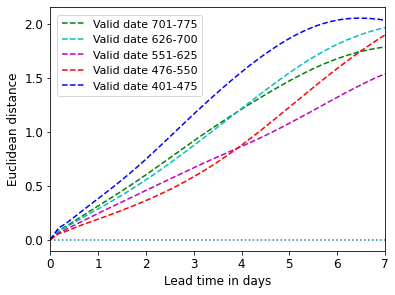

In [19]:
    ##################################################
    ###########       Preview Figure       ###########
    ##################################################    
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    display_upto = 42
   
    std_trajectory_ref = np.ones(display_upto+1,dtype=float)
    trajectory_std = np.std(np.sqrt(x**2 + y**2 + z**2))
    std_trajectory_ref = std_trajectory_ref * trajectory_std
    
    fig05 = plt.figure()
    fig05.set_size_inches(5.6, 4.2, forward=True)
    
    mix_1 = (np.mean(EuD_1[:],0) + np.mean(EuD_origin[:],0))/2
    mix_2 = (np.mean(EuD_2[:],0) + np.mean(EuD_origin[:],0))/2
    
    plt.plot(np.arange(display_upto+1), mix_2[:display_upto+1], color='g', ls='--', label='Valid date 701-775')
    plt.plot(np.arange(display_upto+1), mix_1[:display_upto+1], color='c', ls='--', label='Valid date 626-700')
    plt.plot(np.arange(display_upto+1), np.mean(EuD_2[:,:display_upto+1],0), color='m', ls='--', label='Valid date 551-625')
    plt.plot(np.arange(display_upto+1), np.mean(EuD_1[:,:display_upto+1],0), color='r', ls='--', label='Valid date 476-550')
    plt.plot(np.arange(display_upto+1), np.mean(EuD_origin[:,:display_upto+1],0), color='b', ls='--', label='Valid date 401-475')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto)
    plt.xticks(np.arange(0,display_upto+1,3),fontsize=12)
    
    plt.ylabel("Euclidean distance", fontsize=12)
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1))
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.legend(frameon=True, prop={'size': 11.0}, bbox_to_anchor=(0.005,0.99), loc=2, ncol=1)
    #plt.legend(frameon=True, prop={'size': 11.0}, bbox_to_anchor=(0.99,0.05), loc=4, ncol=1)
    plt.tight_layout()

    plt.show()
    fig05.savefig(os.path.join(output_path_fig,'euclidean_robust_multiDates.png'),dpi=150)